# Imports and spark config

In [8]:
import os

# Set SPARK_HOME
os.environ["SPARK_HOME"] = r"C:/Spark/spark-3.5.0-bin-hadoop3"

# Set PYTHONPATH
spark_home = os.environ.get("SPARK_HOME", "")
if spark_home:
    python_path = os.path.join(spark_home, "python")
    py4j_zip = os.path.join(spark_home, "python", "lib", "py4j-0.10.9.7-src.zip")
    os.environ["PYTHONPATH"] = f"{python_path};{py4j_zip};{os.environ.get('PYTHONPATH', '')}"

# Set PYSPARK_PYTHON
os.environ["PYSPARK_PYTHON"] = "python3"

# Set PATH
if spark_home:
    os.environ["PATH"] = f"{python_path};{os.path.join(spark_home, 'bin')};{os.environ.get('PATH', '')}"

In [9]:
import findspark
findspark.init()

import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

In [10]:
spark = SparkSession.builder.appName("spark").config("spark.driver.memory", "32g").getOrCreate()
spark

In [11]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)

In [12]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

# Data preparation

In [13]:
df = spark.read.parquet(r"c:\Users\Vincenzo\PROJECTS\DDAM_data\brewery\brewery_data_complete_extended.parquet")
type(df)

pyspark.sql.dataframe.DataFrame

In [14]:
df.printSchema()
rows = df.count()
cols = len(df.columns)

print(f'Dimension of the Dataframe is: {(rows,cols)}')
df.show(5)

root
 |-- Batch_ID: long (nullable = true)
 |-- Brew_Date: string (nullable = true)
 |-- Beer_Style: string (nullable = true)
 |-- SKU: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- Fermentation_Time: long (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- pH_Level: double (nullable = true)
 |-- Gravity: double (nullable = true)
 |-- Alcohol_Content: double (nullable = true)
 |-- Bitterness: long (nullable = true)
 |-- Color: long (nullable = true)
 |-- Ingredient_Ratio: string (nullable = true)
 |-- Volume_Produced: long (nullable = true)
 |-- Total_Sales: double (nullable = true)
 |-- Quality_Score: double (nullable = true)
 |-- Brewhouse_Efficiency: double (nullable = true)
 |-- Loss_During_Brewing: double (nullable = true)
 |-- Loss_During_Fermentation: double (nullable = true)
 |-- Loss_During_Bottling_Kegging: double (nullable = true)

Dimension of the Dataframe is: (10000000, 20)
+--------+-------------------+----------+----+------------+--

In [15]:
sample = df.sample(fraction=0.1, seed=42).drop("Batch_ID")

In [16]:
summary_stats = sample.toPandas().describe()
rounded_describe = np.round(summary_stats, 2)

In [17]:
rounded_describe

,Fermentation_Time,Temperature,pH_Level,Gravity,Alcohol_Content,Bitterness,Color,Volume_Produced,Total_Sales,Quality_Score,Brewhouse_Efficiency,Loss_During_Brewing,Loss_During_Fermentation,Loss_During_Bottling_Kegging
count,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00,1001591.00
mean,14.50,20.00,5.00,1.06,5.25,39.52,12.00,2749.48,10491.48,8.00,79.99,3.00,3.00,3.00
std,2.87,2.89,0.29,0.01,0.43,11.54,4.32,1298.31,5486.58,1.15,5.78,1.15,1.16,1.15
min,10.00,15.00,4.50,1.03,4.50,20.00,5.00,500.00,1000.00,6.00,70.00,1.00,1.00,1.00
25%,12.00,17.50,4.75,1.04,4.88,30.00,8.00,1624.00,5747.89,7.00,74.98,2.00,2.00,2.00
50%,15.00,20.00,5.00,1.06,5.25,40.00,12.00,2751.00,10486.75,8.00,79.99,3.00,3.00,3.00
75%,17.00,22.51,5.25,1.07,5.63,50.00,16.00,3874.00,15240.40,9.00,85.00,4.00,4.00,4.00
max,19.00,25.00,5.50,1.08,6.00,59.00,19.00,4999.00,19999.97,10.00,90.00,5.00,5.00,5.00


In [18]:
from pyspark.sql.functions import split, col

# Split the ratio_column into three parts based on the colon delimiter
split_col = split(col("Ingredient_Ratio"), ":")

# Create three separate columns for water, grains, and hops
sample = sample.withColumn("water", split_col.getItem(0).cast("float"))
sample = sample.withColumn("grains", split_col.getItem(1).cast("float"))
sample = sample.withColumn("hops", split_col.getItem(2).cast("float"))
sample = sample.drop("Ingredient_Ratio")
# Now you have three separate columns for water, grains, and hops with their respective values

In [19]:
# Define a new column with the USD per liter ratio
sample = sample.withColumn("USD_per_Liter", F.col("Total_Sales") / F.col("Volume_Produced"))

In [20]:
from pyspark.sql.types import StringType

# Identify numerical and non-numerical columns
numerical_cols = [col_name for col_name, data_type in sample.dtypes if data_type != 'string']
categorical_cols = [col_name for col_name, data_type in sample.dtypes if data_type == 'string']

print(f'Numerical columns: {numerical_cols}')
print(f'Categorical columns: {categorical_cols}')

Numerical columns: ['Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'water', 'grains', 'hops', 'USD_per_Liter']
Categorical columns: ['Brew_Date', 'Beer_Style', 'SKU', 'Location']


In [21]:
distinct_num_counts = {}

for col in numerical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_num_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

print(distinct_num_counts)

- Fermentation_Time - 10 distinct values
- Temperature - 1001591 distinct values
- pH_Level - 1001591 distinct values
- Gravity - 1001591 distinct values
- Alcohol_Content - 1001591 distinct values
- Bitterness - 40 distinct values
- Color - 15 distinct values
- Volume_Produced - 4500 distinct values
- Total_Sales - 1001591 distinct values
- Quality_Score - 1001591 distinct values
- Brewhouse_Efficiency - 1001591 distinct values
- Loss_During_Brewing - 1001591 distinct values
- Loss_During_Fermentation - 1001591 distinct values
- Loss_During_Bottling_Kegging - 1001591 distinct values
- water - 1 distinct values
- grains - 31 distinct values
- hops - 21 distinct values
- USD_per_Liter - 1001591 distinct values
{'Fermentation_Time': 10, 'Temperature': 1001591, 'pH_Level': 1001591, 'Gravity': 1001591, 'Alcohol_Content': 1001591, 'Bitterness': 40, 'Color': 15, 'Volume_Produced': 4500, 'Total_Sales': 1001591, 'Quality_Score': 1001591, 'Brewhouse_Efficiency': 1001591, 'Loss_During_Brewing': 

In [24]:
distinct_cat_counts = {}

for col in categorical_cols:
    distinct_count = sample.select(col).distinct().count()
    distinct_cat_counts[col] = distinct_count

    print(f"- {col} - {distinct_count} distinct values")

print(distinct_cat_counts)

- Brew_Date - 997634 distinct values
- Beer_Style - 8 distinct values
- SKU - 4 distinct values
- Location - 10 distinct values
{'Brew_Date': 997634, 'Beer_Style': 8, 'SKU': 4, 'Location': 10}


# Data Exploration

In [25]:
# small_num_distinct = [col for col in numerical_cols if sample.select(col).distinct().count() <= 10]
# print(small_num_distinct)

numerical_cols.remove("water")
small_num_distinct = ['Fermentation_Time']

In [26]:
histogram = []
histogram += [col for col in numerical_cols if col not in small_num_distinct or col != "water"]

print(histogram)

['Fermentation_Time', 'Temperature', 'pH_Level', 'Gravity', 'Alcohol_Content', 'Bitterness', 'Color', 'Volume_Produced', 'Total_Sales', 'Quality_Score', 'Brewhouse_Efficiency', 'Loss_During_Brewing', 'Loss_During_Fermentation', 'Loss_During_Bottling_Kegging', 'grains', 'hops', 'USD_per_Liter']


In [27]:
# # Step 2: Plot histograms for numerical columns
# for col in numerical_cols:
#     plt.figure(figsize=(4, 3))
#     sns.histplot(data=sample.select(col).toPandas(), x=col, kde=True)
#     plt.title(f'Histogram for {col}')
#     plt.xlabel(col)
#     plt.ylabel('Frequency')
#     plt.show()

In [28]:
# Step 3: Plot bar plots for categorical columns
print(categorical_cols + small_num_distinct)

['Brew_Date', 'Beer_Style', 'SKU', 'Location', 'Fermentation_Time']


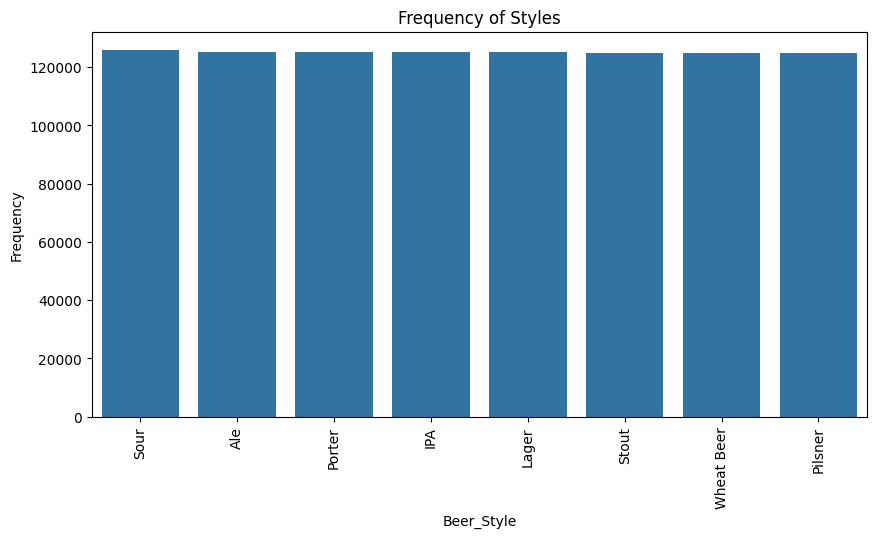

In [29]:
style_frequency = sample.groupBy("Beer_Style").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=style_frequency, x="Beer_Style", y="count", order=style_frequency.sort_values('count', ascending=False)["Beer_Style"])
plt.title('Frequency of Styles')
plt.xlabel('Beer_Style')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

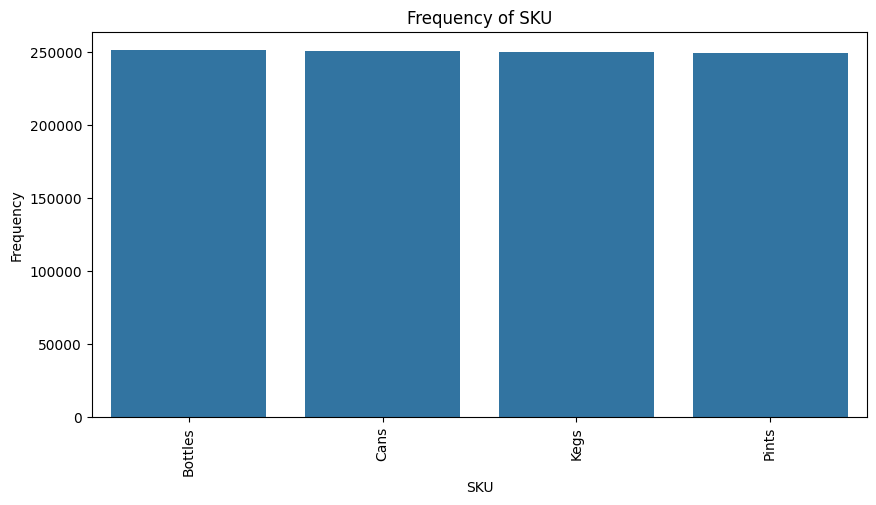

In [30]:
sku_frequency = sample.groupBy("SKU").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=sku_frequency, x="SKU", y="count", order=(sku_frequency.sort_values(by="count", ascending=False))['SKU'])
plt.title('Frequency of SKU')
plt.xlabel('SKU')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

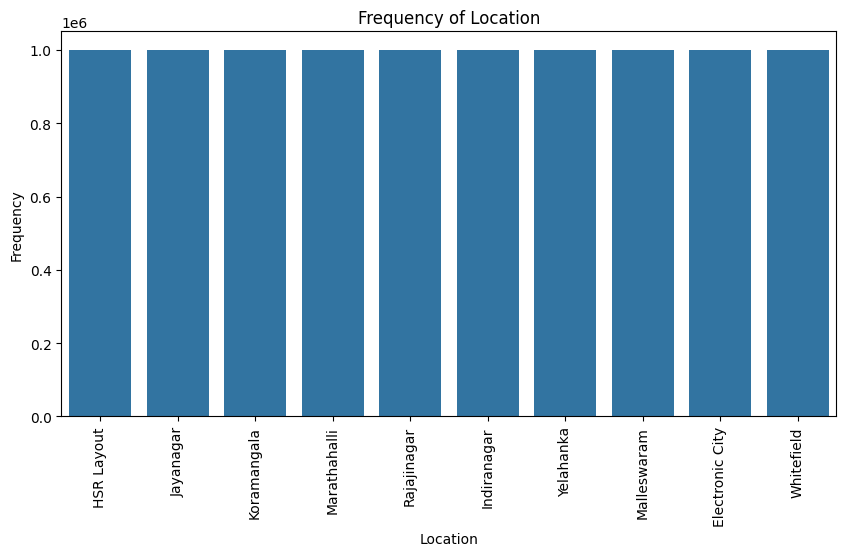

In [31]:
location_frequency = df.groupBy("Location").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=location_frequency, x="Location", y="count", order=(location_frequency.sort_values(by="count", ascending=False))['Location'])
plt.title('Frequency of Location')
plt.xlabel('Location')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

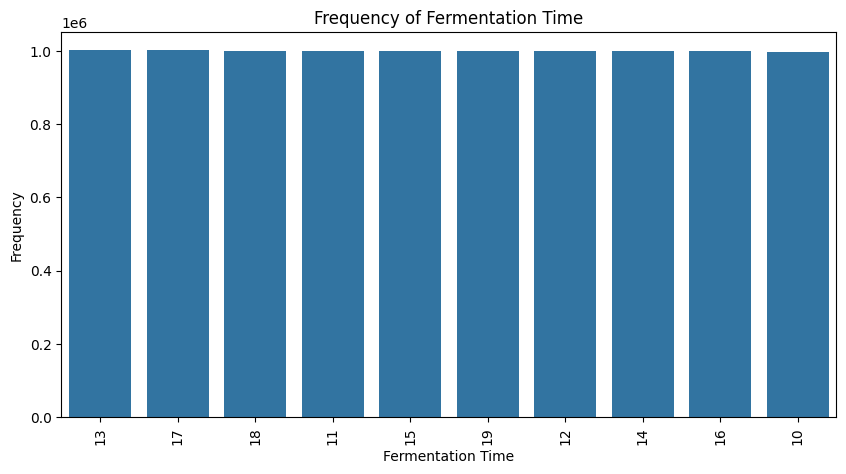

In [32]:
fermentation_frequency = df.groupBy("Fermentation_Time").count().toPandas()

plt.figure(figsize=(10, 5))
sns.barplot(data=fermentation_frequency, x="Fermentation_Time", y="count", order=(fermentation_frequency.sort_values(by="count", ascending=False))['Fermentation_Time'])
plt.title('Frequency of Fermentation Time')
plt.xlabel('Fermentation Time')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()


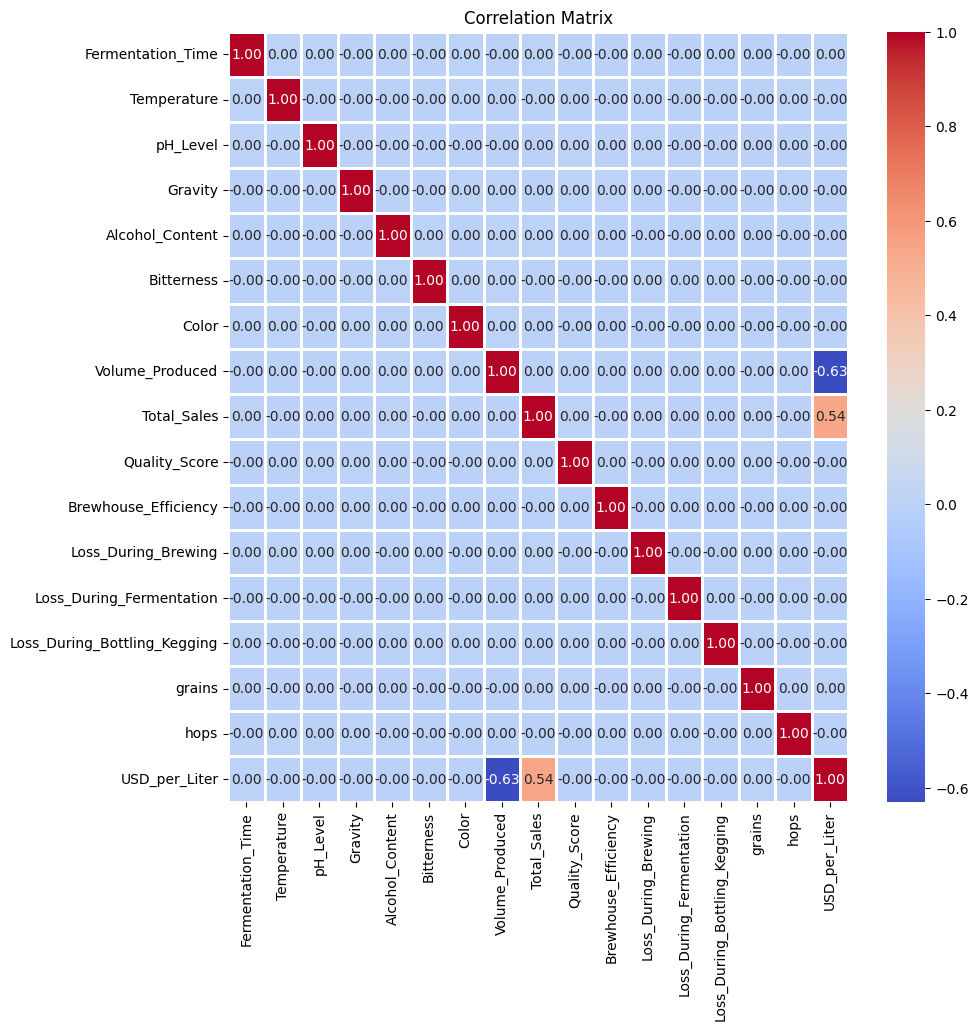

In [33]:
# plot the correlation matrix

corr = sample.select(numerical_cols).toPandas().corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

# Closing statements